In [2]:
import datetime
import json
import warnings

import numpy as np
import rasterio
import requests
import stac
import wtss
import xarray as xr
from pyproj import CRS, Proj, transform
from rasterio.windows import Window

import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

from eocube import EOCube, config

warnings.filterwarnings("ignore")

config.ACCESS_TOKEN = "a6gB61oddyHxMAZ08y098ynEq0s1hQ3siDZao245CV"

In [3]:
%%time
# https://www.keene.edu/campus/maps/tool/
bbox = [-46.4879608, -23.4298590, -46.0917664, -23.6891758]

# Implementar o paralelismo com dask
# Conectar a classe Image com os items do cubo
eocube_service = EOCube(
    collections=["CB4_64_16D_STK-1"],
    query_bands=['red', 'green', 'blue', 'nir'],
    bbox=bbox,
    start_date="2000-01-01",
    end_date="2021-01-01",
    limit=50
)

CPU times: user 12.1 s, sys: 2.81 s, total: 14.9 s
Wall time: 1min 41s


In [4]:
# eocube_service.getDataCube?
data = eocube_service.getDataCube()
data.time

<xarray.DataArray 'time' (time: 50)>
array(['2018-10-16T00:00:00.000000000', '2018-11-01T00:00:00.000000000',
       '2018-11-17T00:00:00.000000000', '2018-12-03T00:00:00.000000000',
       '2018-12-19T00:00:00.000000000', '2019-01-01T00:00:00.000000000',
       '2019-01-17T00:00:00.000000000', '2019-02-02T00:00:00.000000000',
       '2019-02-18T00:00:00.000000000', '2019-03-06T00:00:00.000000000',
       '2019-03-22T00:00:00.000000000', '2019-04-07T00:00:00.000000000',
       '2019-04-23T00:00:00.000000000', '2019-05-09T00:00:00.000000000',
       '2019-05-25T00:00:00.000000000', '2019-06-10T00:00:00.000000000',
       '2019-06-26T00:00:00.000000000', '2019-07-12T00:00:00.000000000',
       '2019-07-28T00:00:00.000000000', '2019-08-13T00:00:00.000000000',
       '2019-08-29T00:00:00.000000000', '2019-09-14T00:00:00.000000000',
       '2019-09-30T00:00:00.000000000', '2019-10-16T00:00:00.000000000',
       '2019-11-01T00:00:00.000000000', '2019-11-17T00:00:00.000000000',
       '2019-12-03T00:00:00.000000000', '2019-12-19T00:00:00.000000000',
       '2020-01-01T00:00:00.000000000', '2020-01-17T00:00:00.000000000',
       '2020-02-18T00:00:00.000000000', '2020-03-05T00:00:00.000000000',
       '2020-03-21T00:00:00.000000000', '2020-04-06T00:00:00.000000000',
       '2020-04-22T00:00:00.000000000', '2020-05-08T00:00:00.000000000',
       '2020-06-09T00:00:00.000000000', '2020-06-25T00:00:00.000000000',
       '2020-07-11T00:00:00.000000000', '2020-07-27T00:00:00.000000000',
       '2020-08-12T00:00:00.000000000', '2020-08-28T00:00:00.000000000',
       '2020-09-13T00:00:00.000000000', '2020-09-29T00:00:00.000000000',
       '2020-10-15T00:00:00.000000000', '2020-10-31T00:00:00.000000000',
       '2020-11-16T00:00:00.000000000', '2020-12-02T00:00:00.000000000',
       '2020-12-18T00:00:00.000000000', '2021-01-01T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2018-10-16 2018-11-01 ... 2021-01-01

In [5]:
data.attrs['CB4_64_16D_STK-1']['title']

'CBERS-4 - AWFI - Cube Stack 16 days - v001'

In [26]:
time_series = eocube_service.getTimeSeries('nir', '2018-01-01', '2021-01-01', -46.2411118, -23.5674487)
time_series

<xarray.DataArray ['DataCube'] (time: 50)>
array([ 3391,  2979,  3355,  3557,  3071,  3462,  3267,  7570,  2233,
        3052,  3798,  2624,  3250,  2513,  2781,  3121,  3064,  2350,
        2268,  4536,  2382,  2643,  2775,  3315,  8939,  3435,  3472,
        2901,  3406,  2893,  3174,  1798,  3121,  2848,  3041,  2529,
        2410,  2411,  2659,  2913, -9999,  2881,  2843,  3016,  3031,
        3080,  3596,  3182,  4335,  3291], dtype=int16)
Coordinates:
    band     <U5 'nir'
  * time     (time) datetime64[ns] 2018-10-16 2018-11-01 ... 2021-01-01
    y        int64 248
    x        int64 389
Attributes:
    CB4_64_16D_STK-1:  {'id': 'CB4_64_16D_STK-1', 'title': 'CBERS-4 - AWFI - ...

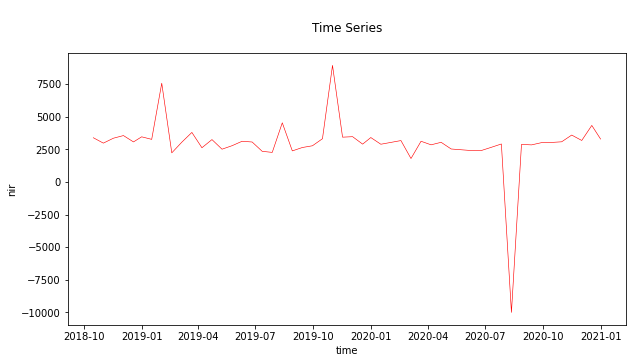

In [27]:
x = time_series.time.values
y = time_series.values

plt.figure(figsize=(10,5))
plt.title(f"\nTime Series\n")
plt.xlabel('time')
plt.ylabel('nir')
plt.plot(x, y, color="red", linewidth=0.6)
plt.show()

In [8]:
red = eocube_service.searchByBand('red')
red

<xarray.DataArray ['DataCube'] (time: 50, y: 428, x: 647)>
array([[[ 795, 1042,  781, ...,  967, 1145, 1095],
        [ 972,  934,  785, ...,  919, 1043, 1023],
        [1082,  784,  780, ..., 1171, 1088,  975],
        ...,
        [ 667,  665,  543, ...,  664,  660,  661],
        [ 659,  632,  514, ...,  682,  686,  699],
        [ 743,  646,  519, ...,  672,  669,  665]],

       [[ 759,  916,  766, ...,  696,  883, 1213],
        [ 795,  941,  754, ...,  556,  754,  971],
        [ 822,  953,  739, ...,  568,  552,  613],
        ...,
        [ 491,  544,  443, ...,  992, 1022, 1414],
        [ 507,  488,  497, ..., 1297, 1307, 1401],
        [ 565,  521,  526, ..., 1172, 1301, 1207]],

       [[1194, 1286, 1175, ...,  951,  952, 1243],
        [1414, 1215, 1179, ...,  803,  803,  889],
        [1416, 1243, 1162, ...,  796, 1001, 1153],
        ...,
...
        ...,
        [ 501,  604,  496, ...,  440,  394,  383],
        [ 519,  556,  488, ...,  396,  374,  354],
        [ 581,  554,  516, ...,  343,  326,  342]],

       [[ 806,  633,  595, ...,  899,  820,  748],
        [1002,  715,  683, ...,  889,  885,  862],
        [1111,  741,  803, ..., 1033, 1090, 1160],
        ...,
        [1903, 1942, 1760, ...,  527,  479,  494],
        [1831, 2064, 1975, ...,  501,  474,  473],
        [1821, 1923, 1993, ...,  437,  447,  450]],

       [[ 883, 1598,  855, ...,  793,  618,  568],
        [ 879, 1502,  672, ...,  617,  563,  590],
        [ 797, 1174,  763, ...,  702,  717,  651],
        ...,
        [ 903,  934,  935, ...,  763,  704,  707],
        [ 868,  922,  952, ...,  677,  625,  653],
        [1087, 1060, 1003, ...,  587,  578,  620]]], dtype=int16)
Coordinates:
    band     <U5 'red'
  * time     (time) datetime64[ns] 2018-10-16 2018-11-01 ... 2021-01-01
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 419 420 421 422 423 424 425 426 427
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 638 639 640 641 642 643 644 645 646
Attributes:
    CB4_64_16D_STK-1:  {'id': 'CB4_64_16D_STK-1', 'title': 'CBERS-4 - AWFI - ...

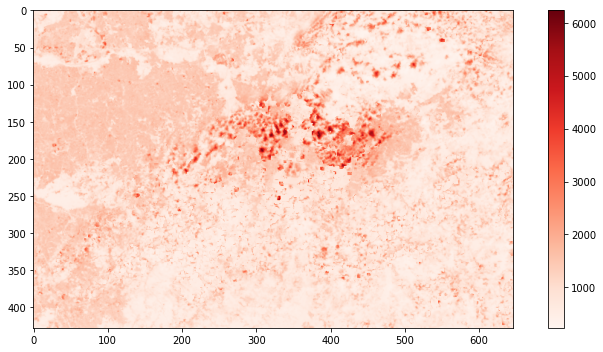

In [17]:
plt.figure(figsize=(10, 5))
colormap = plt.get_cmap('Reds', 1000)
plt.imshow(
    red.values[0],
    cmap=colormap
)
plt.tight_layout()
plt.colorbar()

plt.show()

In [10]:
ndwi = eocube_service.calculateNDWI('2010-01-01')
ndwi

<xarray.DataArray ['ImageNDWI'] (time: 1, y: 428, x: 647)>
array([[[-0.47929859, -0.48840445, -0.52952247, ..., -0.46447338,
         -0.43647799, -0.47682386],
        [-0.46756367, -0.4897413 , -0.53101504, ..., -0.54330048,
         -0.51029748, -0.51188723],
        [-0.43969246, -0.49622857, -0.52784277, ..., -0.46796495,
         -0.4963145 , -0.51818951],
        ...,
        [-0.60099379, -0.56590293, -0.55094131, ..., -0.54547837,
         -0.52214765, -0.52883117],
        [-0.57267951, -0.58927277, -0.59441257, ..., -0.56824513,
         -0.55752212, -0.57422222],
        [-0.54846811, -0.59357231, -0.61201259, ..., -0.59405724,
         -0.58420336, -0.5913884 ]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-10-16
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 419 420 421 422 423 424 425 426 427
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 638 639 640 641 642 643 644 645 646

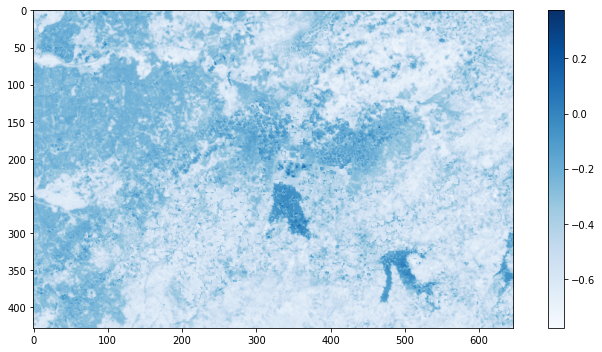

In [11]:
plt.figure(figsize=(10, 5))
colormap = plt.get_cmap('Blues', 1000)
plt.imshow(
    ndwi.values[0],
    cmap=colormap
)
plt.tight_layout()
plt.colorbar()

plt.show()

In [12]:
rgb = eocube_service.calculateColorComposition('2030-01-01')
rgb

<xarray.DataArray ['ColorComposition'] (time: 1, y: 428, x: 647, rgb: 3)>
array([[[[0.10170468, 0.10162866, 0.08350033],
         [0.18405897, 0.17806732, 0.15364061],
         [0.09847961, 0.10814332, 0.07869071],
         ...,
         [0.0913384 , 0.10879479, 0.0757515 ],
         [0.07118176, 0.10010858, 0.06786907],
         [0.06542271, 0.09674267, 0.06973948]],

        [[0.10124395, 0.10238871, 0.0757515 ],
         [0.17300161, 0.16427796, 0.13760855],
         [0.07740152, 0.09261672, 0.06666667],
         ...,
         [0.07106657, 0.09196526, 0.06720107],
         [0.06484681, 0.09055375, 0.06693387],
         [0.06795669, 0.09522258, 0.07187709]],

        [[0.09179912, 0.10141151, 0.0757515 ],
         [0.1352223 , 0.13778502, 0.10634603],
         [0.08788298, 0.10228013, 0.07000668],
         ...,
...
         ...,
         [0.08788298, 0.10749186, 0.08430194],
         [0.08108731, 0.10021716, 0.07107548],
         [0.08143285, 0.10304017, 0.0757515 ]],

        [[0.09997696, 0.13213898, 0.11917168],
         [0.10619673, 0.13344191, 0.12077488],
         [0.10965215, 0.13409338, 0.11917168],
         ...,
         [0.07797742, 0.10412595, 0.08911156],
         [0.07198802, 0.09446254, 0.07201069],
         [0.07521308, 0.09793702, 0.07134269]],

        [[0.12520157, 0.14842562, 0.12919172],
         [0.12209168, 0.14885993, 0.13079492],
         [0.11552638, 0.1402823 , 0.1245157 ],
         ...,
         [0.06761115, 0.09066232, 0.0744155 ],
         [0.06657452, 0.08653637, 0.06720107],
         [0.07141212, 0.09294245, 0.06907148]]]])
Coordinates:
  * time     (time) datetime64[ns] 2021-01-01
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 419 420 421 422 423 424 425 426 427
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 638 639 640 641 642 643 644 645 646
  * rgb      (rgb) <U5 'red' 'green' 'blue'

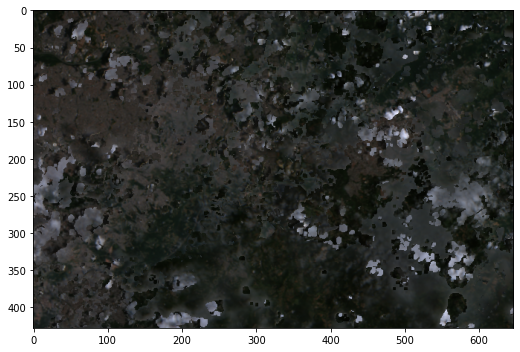

In [14]:
plt.figure(figsize=(10, 5))
plt.imshow(rgb.values[0])
plt.tight_layout()

plt.show()

In [15]:
ndvi = eocube_service.calculateNDVI('2010-01-01')
ndvi

<xarray.DataArray ['ImageNDVI'] (time: 1, y: 428, x: 647)>
array([[[0.58507307, 0.50976241, 0.61259921, ..., 0.53643337,
         0.49901553, 0.53981929],
        [0.5171386 , 0.5629387 , 0.6116745 , ..., 0.6003479 ,
         0.55360582, 0.5567591 ],
        [0.46934772, 0.61350752, 0.61433869, ..., 0.52591093,
         0.54112189, 0.57274321],
        ...,
        [0.65698123, 0.65391621, 0.67523923, ..., 0.63233666,
         0.6223176 , 0.63318535],
        [0.65334035, 0.67763326, 0.72291105, ..., 0.66403941,
         0.65955335, 0.67036076],
        [0.61160481, 0.66606358, 0.73017936, ..., 0.68888889,
         0.67828805, 0.68975974]]])
Coordinates:
  * time     (time) datetime64[ns] 2018-10-16
  * y        (y) int64 0 1 2 3 4 5 6 7 8 ... 419 420 421 422 423 424 425 426 427
  * x        (x) int64 0 1 2 3 4 5 6 7 8 ... 638 639 640 641 642 643 644 645 646

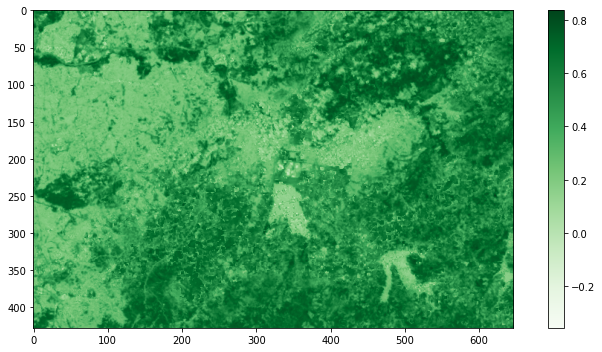

In [16]:
plt.figure(figsize=(10, 5))
colormap = plt.get_cmap('Greens', 1000)
plt.imshow(
    ndvi.values[0],
    cmap=colormap
)
plt.tight_layout()
plt.colorbar()

plt.show()